# "I'm The King of the World! Or Almost...". Predicting Titanic Passengers' Fate through Machine Learning

# Introduction

"What sort of people were more likely to survive?"

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import re 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading the Data

In [2]:
# Reading in the datasets
train_df = pd.read_csv("../data/titanic_data/train.csv")
test_df = pd.read_csv("../data/titanic_data/test.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Dealing With Missing Values

In [3]:
# Creating a function that identifies and plots missing values 
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False) # summing all the null values in the dataset and sorting them in descending order 
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False) # calculating the percentage of the missing values in each feature 
    ms = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # concatenating the total and the percentage missing values in a table 
    ms = ms[ms["Percent"] > 0] # returning only those missing values which have a percentage greater than 0 
    # plotting the missing data
    f,ax = plt.subplots(figsize=(8,6)) 
    plt.xticks(rotation='90') # setting the rotation of the x ticks to 90 degrees 
    fig = sns.barplot(ms.index, ms["Percent"], color="green",alpha=0.8) # creating green barplots 
    plt.xlabel('Features', fontsize=15) # adding a label on the x axis 
    plt.ylabel('Percent of missing values', fontsize=15) # adding a label on the y axis 
    plt.title('Percent missing data by feature', fontsize=15) # adding a title to the graph 
    return ms

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


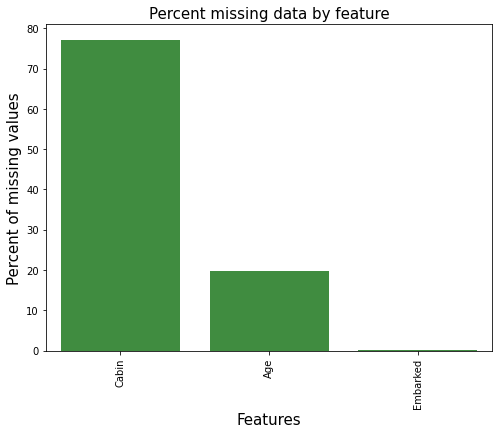

In [4]:
# Identifying missing values in the training set
missingdata(train_df)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


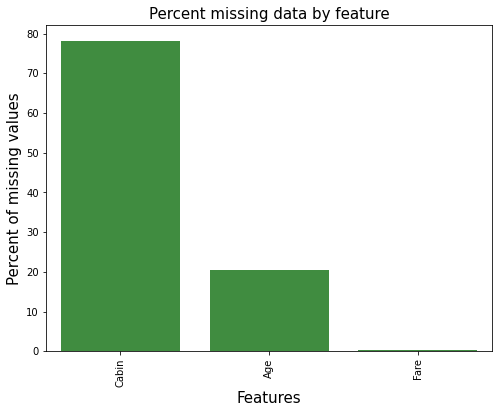

In [5]:
missingdata(test_df)

## Dealing With Missing Values in the Training Set

In [6]:
# Filling missing values in the training set 
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True) # why are we adding [0]? 
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)

# Dropping columns with too many missing values 
drop_column = ['Cabin']
train_df.drop(drop_column, axis=1, inplace = True)
test_df.drop(drop_column, axis=1, inplace=True)

## Dealing With Missing Values in the Test Set

In [9]:
# Using the training set medians to substitute test set NaNs in order to prevent any biases 
test_df['Age'].fillna(train_df['Age'].median(), inplace = True)
test_df['Fare'].fillna(train_df['Age'].median(), inplace = True)

In [11]:
print('check the nan value in train data')
print(train_df.isnull().sum())
print('___'*30)
print('check the nan value in test data')
print(test_df.isnull().sum())

check the nan value in train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
__________________________________________________________________________________________
check the nan value in test data
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


# Feature Engineering

In [12]:
# Combining test and train as single to apply some function
all_data = [train_df, test_df]

In [13]:
# Creating a new feature called FamilySize as a combination of SibSp and Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 # why are we adding 1?

In [14]:
# Creating a new Title feature extracting from existing ones 
for dataset in all_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False) # Extracting the titles from the name column and adding them to a new column called 'Title'
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
                                                 'Rare') # replacing rare titles with the word 'Rare'
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') # replacing other titles with more common ones 
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss') # replacing other titles with more common ones 
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') # replacing other titles with more common ones 

In [15]:
# Creating bins for age features
for dataset in all_data:
    dataset['Age Bin'] = pd.cut(dataset['Age'], bins=[0, 12, 20, 40, 120], labels=['Children','Teenage','Adult','Elder'])

In [16]:
# Creating bins for fare features
for dataset in all_data:
    dataset['Fare Bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low Fare','Median Fare',
                                                                                      'Average Fare','High Fare'])

In [17]:
# Making a copy of both datasets and starting to work for the copy of the datasets 
traindf = train_df
testdf = test_df

In [18]:
combined = [traindf, testdf]

In [19]:
# Dropping unnecessary columns 
for dataset in combined:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [20]:
# Dropping the PassengerId column only in the training set as we will need it in the test set for our predictions 
drop_column = ['PassengerId']
traindf.drop(drop_column, axis=1, inplace = True)

## Converting Categorical Features Into Numerical Ones

In [21]:
# Turning each categorical feature of both datasets into a numerical one 
traindf = pd.get_dummies(traindf, columns = ["Sex","Title","Age Bin","Embarked","Fare Bin"],
                             prefix=["Sex","Title","Age Type","Em Type","Fare Type"])
testdf = pd.get_dummies(testdf, columns = ["Sex","Title","Age Bin","Embarked","Fare Bin"],
                             prefix=["Sex","Title","Age Type","Em Type","Fare Type"])

## Finding Correlation Between Features

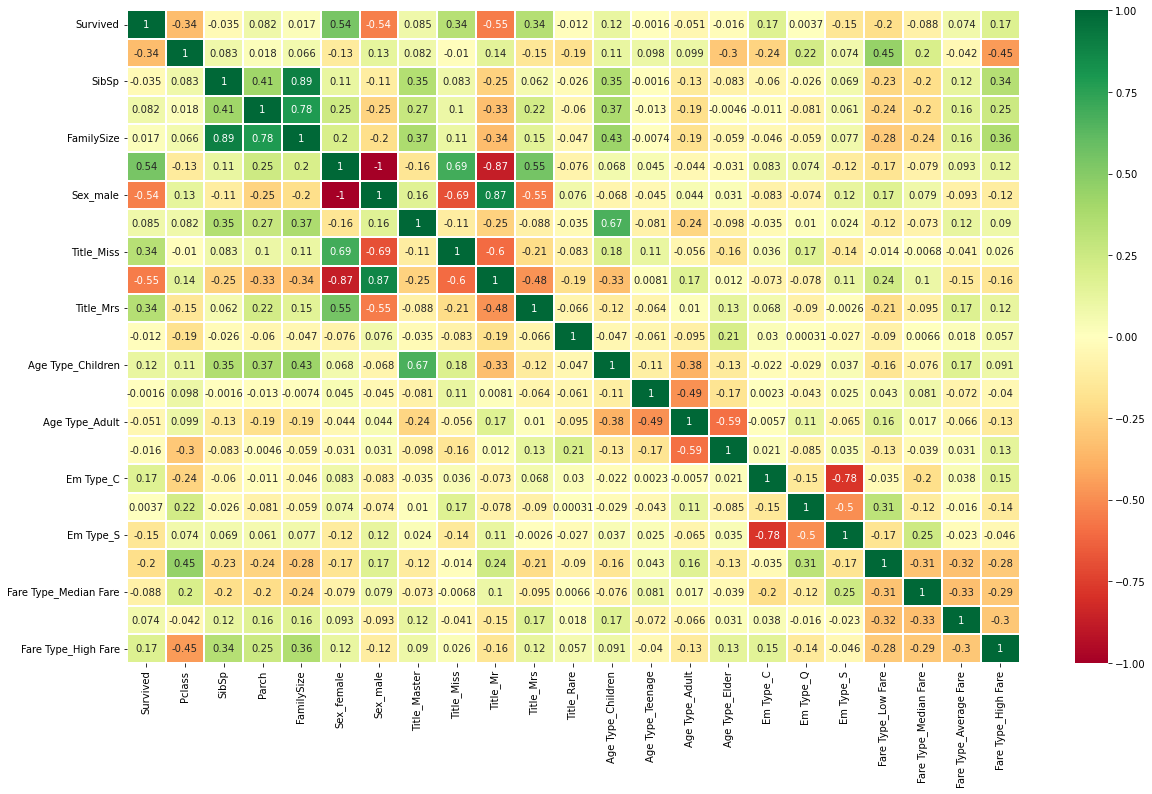

In [22]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

## Pairplots

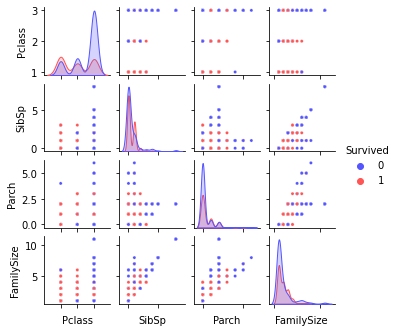

In [23]:
# Generating pairplots to observe the distribution of the data of the features 
g = sns.pairplot(data=train_df, hue='Survived', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Training Our Machine Learning Model 

In [27]:
X_train = train_df.drop("Survived", axis=1) # assigning the training data to a variable named X_train and dropping the Survived column (the value that we want to predict)
Y_train = train_df["Survived"] # assigning the value that we want to predict to Y_train
X_test  = test_df.drop("PassengerId", axis=1).copy() # creating an X_test test set 
X_train.shape, Y_train.shape, X_test.shape # looking at the shape of our sets

((891, 9), (891,), (418, 9))

In [29]:
from sklearn.ensemble import RandomForestClassifier

y = train_df['Survived']

features = ['Pclass', 'Sex', 'SibSp', "Age Bin"]
X = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
